In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import scipy as sp
import numpy as np
from math import sqrt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)


In [5]:
#Estimators
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 

#PreProcessing
from sklearn import preprocessing

#Metrics
from sklearn.metrics import mean_squared_error, confusion_matrix, r2_score, accuracy_score, cohen_kappa_score, classification_report

#Cross-validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict


(30000, 25)


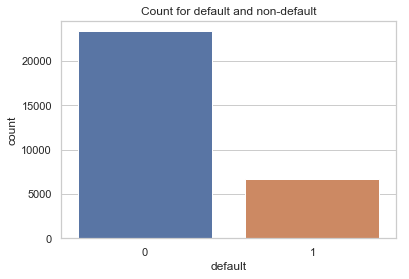

<Figure size 432x288 with 0 Axes>

In [6]:
#read data and update the column names
data = pd.read_csv("data.csv", header = 1)
data = data.rename(columns = {'default payment next month': 'default'})

#Remove mising values
data = data.dropna()
print(data.shape) #no missing values at all

#Group education categories into OTHER
data['EDUCATION'] = np.where(data['EDUCATION'] == 0, 4, data['EDUCATION'])

data['EDUCATION'] = np.where(data['EDUCATION'] == 5, 4, data['EDUCATION'])

data['EDUCATION'] = np.where(data['EDUCATION'] == 6, 4, data['EDUCATION'])

#Take the marriage 0 category out
data['MARRIAGE'] = np.where(data['MARRIAGE'] == 0, 3, data['MARRIAGE'])


sns.countplot(x = 'default', data = data)
plt.title("Count for default and non-default")
plt.show()
plt.savefig('countplot')

percentage of no default is 77.88000000000001
percentage of default 22.12


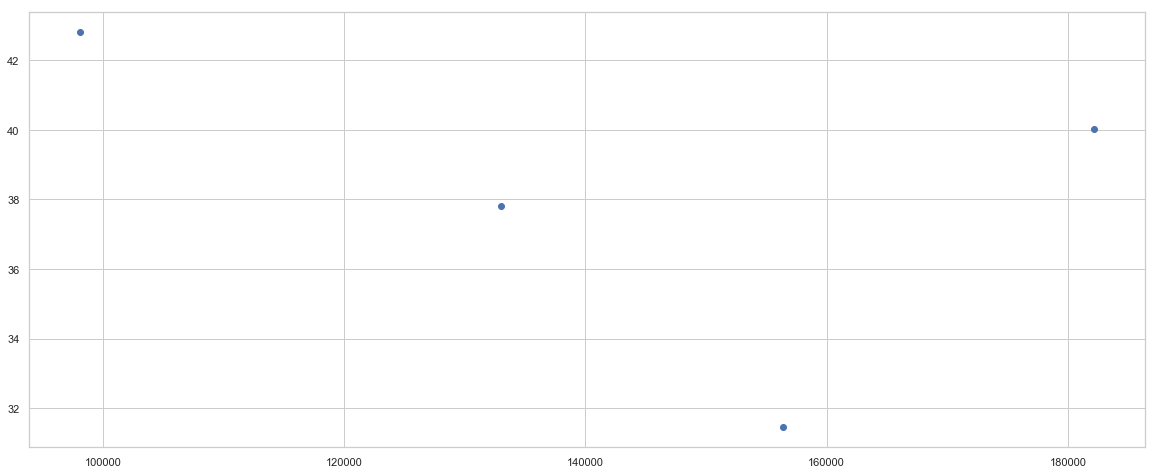

In [173]:
#Group by
mes_marriage = data.groupby('MARRIAGE').mean()
mes_marriage
plt.scatter(x = 'LIMIT_BAL', y = 'AGE', data = mes_marriage)

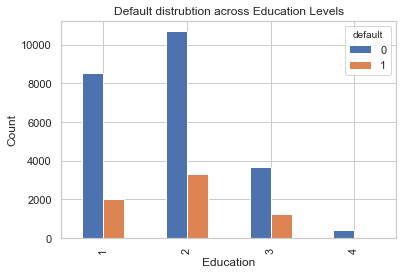

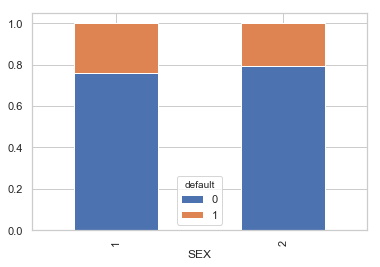

In [194]:
%matplotlib inline
#two-sided bar chart
pd.crosstab(data.EDUCATION, data.default).plot(kind = "bar")
plt.title("Default distrubtion across Education Levels")
plt.xlabel('Education')
plt.ylabel('Count')


#stacked bar chart (%)
table = pd.crosstab(data.SEX, data.default)
table.div(table.sum(1).astype(float), axis = 0).plot(kind = "bar", stacked = True)



In [67]:
#Convert to the right type
data["SEX"] = data["SEX"].astype('category')
data["MARRIAGE"] = data["MARRIAGE"].astype('category')
data["default"] = data["default"].astype('category') #not really needed


In [107]:
#Split dependent from independent
feature = data[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5', 'PAY_AMT6', 'EDUCATION', 'AGE']] #features used

#dependent variable
dependent = data['default'] #feature trying to explain

#normalize dat shit
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(feature)

feature = scaler.transform(feature)



C:\Users\Luca\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Luca\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


In [111]:
#recursive feature elimination (RFE)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


rfe = RFE(classRF, 20)
rfe = rfe.fit(feature, dependent.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [108]:
#Cross-validation
feature, X_test, dependent, y_test = train_test_split(feature, dependent, test_size=0.3, random_state=42)

#Models
classRF = RandomForestClassifier()
classKnn = KNeighborsClassifier(n_neighbors = 5)

print(feature.shape)
print(X_test.shape)


(21000, 14)
(9000, 14)


In [109]:
#Accuracy and kappa for cross-validation (training set)
classRF.fit(feature, dependent)
pred_rf = cross_val_predict(classRF, feature, dependent, cv = 5) #random forest

classKnn.fit(feature, dependent)
pred_knn = cross_val_predict(classKnn, feature, dependent, cv = 5) #knn neighbor = 5


#results for random forest
print('Accuracy RF is:', accuracy_score(dependent, pred_rf))
print('Kappa RF is:', cohen_kappa_score(dependent, pred_rf))
print(cross_val_score(classRF, feature, dependent))

#results for knn
print('Accuracy knn is:', accuracy_score(dependent, pred_knn))
print('Kappa knn is:', cohen_kappa_score(dependent, pred_knn))
print(cross_val_score(classKnn, feature, dependent))

C:\Users\Luca\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy RF is: 0.804047619047619
Kappa RF is: 0.32905158275345714


C:\Users\Luca\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[0.80502785 0.80114286 0.80354336]
Accuracy knn is: 0.7928095238095239
Kappa knn is: 0.3184330214893323


C:\Users\Luca\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[0.80102842 0.79042857 0.78568367]


In [110]:
#Make Predictions
predictions_rf = classRF.predict(X_test)

print('Accuracy is:', accuracy_score(y_test, predictions_rf))
print('Kappa is:', cohen_kappa_score(y_test, predictions_rf))
print(confusion_matrix(y_test, predictions_rf))
print(classification_report(y_test, predictions_rf))



Accuracy is: 0.799
Kappa is: 0.301675019172733
[[6557  483]
 [1326  634]]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      7040
           1       0.57      0.32      0.41      1960

   micro avg       0.80      0.80      0.80      9000
   macro avg       0.70      0.63      0.65      9000
weighted avg       0.77      0.80      0.78      9000

